In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


Using TensorFlow backend.


In [3]:
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "../Flicker8k_text/Flickr8k.token.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [4]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
descriptions['1001773457_577c3a7d70']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [8]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [9]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
descriptions['1001773457_577c3a7d70']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8763


In [12]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [20]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '../Flicker8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [21]:
train

{'2662537919_18a29fca8a',
 '2662816021_ac474e0fde',
 '3429194423_98e911a101',
 '523692399_d2e261a302',
 '2073174497_18b779999c',
 '3558683579_8fb36b55a6',
 '2741051940_89fb6b2cee',
 '2603125422_659391f961',
 '3162442331_c9711857c6',
 '241346471_c756a8f139',
 '3643087589_627a0a9e01',
 '508958120_afe274f726',
 '1507563902_6ec8d5d822',
 '1952896009_cee8147c90',
 '3184206563_5435f2b494',
 '3373870185_f79163fa51',
 '3350785999_462f333c44',
 '3615730936_23457575e9',
 '1187435567_18173c148b',
 '2766726291_b83eb5d315',
 '3562282690_cd2a95fe9e',
 '3577235421_69e4efb8d1',
 '3482314155_bd1e668b4e',
 '2473737724_355599a263',
 '2866529477_7e0c053ebc',
 '3606846822_28c40b933a',
 '3229442620_fd47d01b59',
 '2837799692_2f1c50722a',
 '3431860810_44277cd360',
 '3265578645_4044a7049a',
 '3654869593_c8599a8e20',
 '3738789925_7d17dbdf25',
 '185972340_781d60ccfd',
 '3632047678_f202609e50',
 '2955099064_1815b00825',
 '3667157255_4e66d11dc2',
 '3030824089_e5a840265e',
 '455611732_d65bf3e976',
 '2637510448_4521

In [22]:
# Below path contains all the images
images = '../Flicker8k_Dataset/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [23]:
img

['../Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 '../Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 '../Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 '../Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 '../Flicker8k_Dataset\\1007129816_e794419615.jpg',
 '../Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 '../Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 '../Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 '../Flicker8k_Dataset\\1015118661_980735411b.jpg',
 '../Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg',
 '../Flicker8k_Dataset\\101654506_8eb26cfb60.jpg',
 '../Flicker8k_Dataset\\101669240_b2d3e7f17b.jpg',
 '../Flicker8k_Dataset\\1016887272_03199f49c4.jpg',
 '../Flicker8k_Dataset\\1019077836_6fc9b15408.jpg',
 '../Flicker8k_Dataset\\1019604187_d087bf9a5f.jpg',
 '../Flicker8k_Dataset\\1020651753_06077ec457.jpg',
 '../Flicker8k_Dataset\\1022454332_6af2c1449a.jpg',
 '../Flicker8k_Dataset\\1022454428_b6b660a67b.jpg',
 '../Flicker8k_Dataset\\1022975728_75515238d8.jpg',
 '../Flicker8k

In [26]:
# Below file conatains the names of images to be used in train data
train_images_file = '../Flicker8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [27]:
train_img

['../Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 '../Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 '../Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 '../Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 '../Flicker8k_Dataset\\1007129816_e794419615.jpg',
 '../Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 '../Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 '../Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 '../Flicker8k_Dataset\\1015118661_980735411b.jpg',
 '../Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg',
 '../Flicker8k_Dataset\\101654506_8eb26cfb60.jpg',
 '../Flicker8k_Dataset\\101669240_b2d3e7f17b.jpg',
 '../Flicker8k_Dataset\\1016887272_03199f49c4.jpg',
 '../Flicker8k_Dataset\\1019077836_6fc9b15408.jpg',
 '../Flicker8k_Dataset\\1019604187_d087bf9a5f.jpg',
 '../Flicker8k_Dataset\\1020651753_06077ec457.jpg',
 '../Flicker8k_Dataset\\1022454428_b6b660a67b.jpg',
 '../Flicker8k_Dataset\\1022975728_75515238d8.jpg',
 '../Flicker8k_Dataset\\102351840_323e3de834.jpg',
 '../Flicker8k_

In [28]:
# Below file conatains the names of images to be used in test data
test_images_file = '../Flicker8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [29]:
test_img

['../Flicker8k_Dataset\\1056338697_4f7d7ce270.jpg',
 '../Flicker8k_Dataset\\106490881_5a2dd9b7bd.jpg',
 '../Flicker8k_Dataset\\1082379191_ec1e53f996.jpg',
 '../Flicker8k_Dataset\\1084040636_97d9633581.jpg',
 '../Flicker8k_Dataset\\1096395242_fc69f0ae5a.jpg',
 '../Flicker8k_Dataset\\1107246521_d16a476380.jpg',
 '../Flicker8k_Dataset\\1119015538_e8e796281e.jpg',
 '../Flicker8k_Dataset\\1122944218_8eb3607403.jpg',
 '../Flicker8k_Dataset\\1131800850_89c7ffd477.jpg',
 '../Flicker8k_Dataset\\1131932671_c8d17751b3.jpg',
 '../Flicker8k_Dataset\\113678030_87a6a6e42e.jpg',
 '../Flicker8k_Dataset\\114051287_dd85625a04.jpg',
 '../Flicker8k_Dataset\\115684808_cb01227802.jpg',
 '../Flicker8k_Dataset\\1167669558_87a8a467d6.jpg',
 '../Flicker8k_Dataset\\1174525839_7c1e6cfa86.jpg',
 '../Flicker8k_Dataset\\1174629344_a2e1a2bdbf.jpg',
 '../Flicker8k_Dataset\\1220401002_3f44b1f3f7.jpg',
 '../Flicker8k_Dataset\\1224851143_33bcdd299c.jpg',
 '../Flicker8k_Dataset\\1237985362_dbafc59280.jpg',
 '../Flicker8k_D

In [30]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [31]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [32]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')









96116736/96112376 [==============================] - 166s 2us/step


In [33]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [94]:
model_new.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

batch_normalization_16 (BatchNo (None, 35, 35, 64)   192         conv2d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 35, 35, 64)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 35, 35, 48)   12288       mixed0[0][0]                     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 35, 35, 96)   55296       activation_16[0][0]              
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 35, 35, 48)   144         conv2d_14[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_25 (Activation)      (None, 35, 35, 96)   0           batch_normalization_25[0][0]     
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 35, 35, 64)   0           batch_normalization_26[0][0]     
__________________________________________________________________________________________________
mixed2 (Concatenate)            (None, 35, 35, 288)  0           activation_20[0][0]              
                                                                 activation_22[0][0]              
                                                                 activation_25[0][0]              
                                                                 activation_26[0][0]              
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 35, 35, 64)   18432       mixed2[0][0]                     
__________

__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 17, 17, 192)  576         conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 17, 17, 192)  576         conv2d_34[0][0]                  
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 17, 17, 192)  576         conv2d_39[0][0]                  
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 17, 17, 192)  576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 17, 17, 192)  0           batch_normalization_31[0][0]     
__________

mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_51[0][0]              
                                                                 activation_54[0][0]              
                                                                 activation_59[0][0]              
                                                                 activation_60[0][0]              
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 17, 17, 192)  576         conv2d_65[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 17, 17, 192)  0           batch_normalization_65[0][0]     
__________

conv2d_75 (Conv2D)              (None, 17, 17, 192)  258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, 17, 17, 192)  576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_normalization_75 (BatchNo (None, 17, 17, 192)  576         conv2d_75[0][0]                  
__________________________________________________________________________________________________
activation_71 (Activation)      (None, 17, 17, 192)  0           batch_normalization_71[0][0]     
__________________________________________________________________________________________________
activation_75 (Activation)      (None, 17, 17, 192)  0           batch_normalization_75[0][0]     
__________________________________________________________________________________________________
conv2d_72 

conv2d_90 (Conv2D)              (None, 8, 8, 448)    917504      mixed9[0][0]                     
__________________________________________________________________________________________________
batch_normalization_90 (BatchNo (None, 8, 8, 448)    1344        conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_90 (Activation)      (None, 8, 8, 448)    0           batch_normalization_90[0][0]     
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 8, 8, 384)    786432      mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_91 (Conv2D)              (None, 8, 8, 384)    1548288     activation_90[0][0]              
__________________________________________________________________________________________________
batch_norm

In [34]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [35]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 1583.0282485485077


In [47]:
dump(encoding_train, open('encoded_train_images.pkl', 'wb'))

In [48]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 292.0169460773468


In [49]:
dump(encoding_test, open('encoded_test_images.pkl', 'wb'))

In [50]:
train_features = load(open("encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [51]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [85]:
all_train_captions

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tricolored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq',
 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
 'startseq little girl is sitting in front of large painted rainbow endseq',
 'startseq small girl in the grass plays with fingerpaints in front of white canvas w

In [86]:
len(all_train_captions)

30000

In [52]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 -> 1651


In [87]:
vocab

['startseq',
 'child',
 'in',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'set',
 'of',
 'stairs',
 'an',
 'way',
 'endseq',
 'girl',
 'going',
 'into',
 'wooden',
 'building',
 'little',
 'the',
 'to',
 'her',
 'black',
 'dog',
 'and',
 'spotted',
 'are',
 'fighting',
 'tricolored',
 'playing',
 'with',
 'each',
 'other',
 'on',
 'road',
 'white',
 'brown',
 'spots',
 'staring',
 'at',
 'street',
 'two',
 'dogs',
 'different',
 'looking',
 'pavement',
 'moving',
 'toward',
 'covered',
 'paint',
 'sits',
 'front',
 'painted',
 'rainbow',
 'hands',
 'bowl',
 'sitting',
 'large',
 'small',
 'grass',
 'plays',
 'it',
 'there',
 'pigtails',
 'painting',
 'young',
 'outside',
 'man',
 'lays',
 'bench',
 'while',
 'his',
 'by',
 'him',
 'which',
 'also',
 'tied',
 'sleeping',
 'next',
 'shirtless',
 'lies',
 'park',
 'laying',
 'holding',
 'leash',
 'ground',
 'orange',
 'hat',
 'something',
 'wears',
 'glasses',
 'wearing',
 'beer',
 'can',
 'ears',
 'rope',
 'net',
 'red',
 'climbs',
 '

In [88]:
word_counts

{'startseq': 30000,
 'child': 1120,
 'in': 14085,
 'pink': 543,
 'dress': 260,
 'is': 6907,
 'climbing': 375,
 'up': 903,
 'set': 81,
 'of': 4967,
 'stairs': 81,
 'an': 1807,
 'entry': 1,
 'way': 41,
 'endseq': 30000,
 'girl': 2414,
 'going': 111,
 'into': 757,
 'wooden': 209,
 'building': 373,
 'little': 1266,
 'playhouse': 6,
 'the': 13509,
 'to': 2303,
 'her': 861,
 'cabin': 3,
 'black': 2854,
 'dog': 6159,
 'and': 6672,
 'spotted': 27,
 'are': 2619,
 'fighting': 97,
 'tricolored': 10,
 'playing': 1486,
 'with': 5763,
 'each': 318,
 'other': 567,
 'on': 8006,
 'road': 305,
 'white': 2921,
 'brown': 1995,
 'spots': 22,
 'staring': 43,
 'at': 2101,
 'street': 703,
 'two': 4246,
 'dogs': 1620,
 'different': 28,
 'breeds': 5,
 'looking': 563,
 'pavement': 39,
 'moving': 27,
 'toward': 109,
 'covered': 229,
 'paint': 44,
 'sits': 437,
 'front': 996,
 'painted': 50,
 'rainbow': 18,
 'hands': 180,
 'bowl': 21,
 'sitting': 1018,
 'large': 894,
 'small': 940,
 'grass': 1222,
 'plays': 392,
 

In [53]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [54]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1652

In [58]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [59]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [60]:
# Load Glove vectors
glove_dir = '../glove.6B/'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [61]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [62]:
embedding_matrix.shape

(1652, 200)

In [63]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 

In [65]:
model.layers[2]

In [66]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [67]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [68]:
epochs = 2
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [69]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 706s 353ms/step - loss: 4.1298
Epoch 1/1
2000/2000 [==============================] - 621s 311ms/step - loss: 3.4188


In [70]:
epochs = 8
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [90]:
train_features['1000268201_693b08cb0e.jpg'].shape

(2048,)

In [91]:
train_features['1003163366_44323f5815.jpg']

array([0.48603082, 0.29218352, 0.3143677 , ..., 0.9825475 , 0.2810801 ,
       0.22330065], dtype=float32)

In [92]:
train_features['1003163366_44323f5815.jpg'].shape

(2048,)

In [93]:
wordtoix

{'startseq': 1,
 'child': 2,
 'in': 3,
 'pink': 4,
 'dress': 5,
 'is': 6,
 'climbing': 7,
 'up': 8,
 'set': 9,
 'of': 10,
 'stairs': 11,
 'an': 12,
 'way': 13,
 'endseq': 14,
 'girl': 15,
 'going': 16,
 'into': 17,
 'wooden': 18,
 'building': 19,
 'little': 20,
 'the': 21,
 'to': 22,
 'her': 23,
 'black': 24,
 'dog': 25,
 'and': 26,
 'spotted': 27,
 'are': 28,
 'fighting': 29,
 'tricolored': 30,
 'playing': 31,
 'with': 32,
 'each': 33,
 'other': 34,
 'on': 35,
 'road': 36,
 'white': 37,
 'brown': 38,
 'spots': 39,
 'staring': 40,
 'at': 41,
 'street': 42,
 'two': 43,
 'dogs': 44,
 'different': 45,
 'looking': 46,
 'pavement': 47,
 'moving': 48,
 'toward': 49,
 'covered': 50,
 'paint': 51,
 'sits': 52,
 'front': 53,
 'painted': 54,
 'rainbow': 55,
 'hands': 56,
 'bowl': 57,
 'sitting': 58,
 'large': 59,
 'small': 60,
 'grass': 61,
 'plays': 62,
 'it': 63,
 'there': 64,
 'pigtails': 65,
 'painting': 66,
 'young': 67,
 'outside': 68,
 'man': 69,
 'lays': 70,
 'bench': 71,
 'while': 72,
 

In [71]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 670s 335ms/step - loss: 3.1959
Epoch 1/1
2000/2000 [==============================] - 734s 367ms/step - loss: 3.0623
Epoch 1/1
2000/2000 [==============================] - 773s 387ms/step - loss: 2.9658
Epoch 1/1
2000/2000 [==============================] - 819s 409ms/step - loss: 2.8933
Epoch 1/1
2000/2000 [==============================] - 877s 438ms/step - loss: 2.8373
Epoch 1/1
2000/2000 [==============================] - 929s 465ms/step - loss: 2.7906
Epoch 1/1
2000/2000 [==============================] - 988s 494ms/step - loss: 2.7489
Epoch 1/1
2000/2000 [==============================] - 1040s 520ms/step - loss: 2.7164


In [72]:
model.save_weights('./model_weights/model_10.h5')

In [73]:
images = '../Flicker8k_Dataset/'

In [74]:
with open("encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [75]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

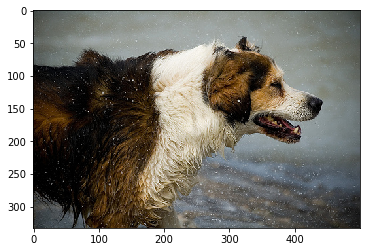

Greedy: dog is walking through the water


In [79]:
z=8
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

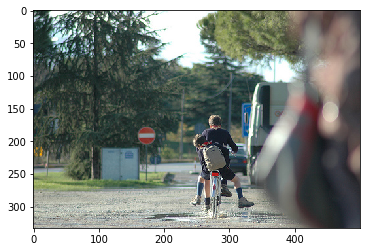

Greedy: man wearing helmet and hat is riding bike down the street


In [83]:
z=500
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

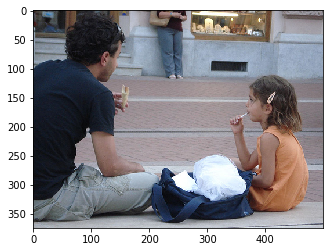

Greedy: two children are sitting on the floor in front of building


In [84]:
z=100
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))

In [126]:
from keras.preprocessing.image import load_img
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
new_image="../example.jpg"

In [127]:
img = load_img(new_image, target_size=(150,150))

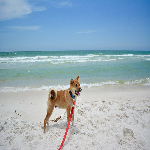

In [128]:
img

In [130]:
test_image = image.img_to_array(img)

In [132]:
test_image.shape

(150, 150, 3)

In [134]:
img_data=encode(new_image)

In [135]:
img_data

array([0.77055985, 0.19425327, 0.53966624, ..., 0.20753668, 1.7675223 ,
       0.24053119], dtype=float32)

In [136]:
img_data.shape

(2048,)

In [113]:
train_img

['../Flicker8k_Dataset\\1000268201_693b08cb0e.jpg',
 '../Flicker8k_Dataset\\1001773457_577c3a7d70.jpg',
 '../Flicker8k_Dataset\\1002674143_1b742ab4b8.jpg',
 '../Flicker8k_Dataset\\1003163366_44323f5815.jpg',
 '../Flicker8k_Dataset\\1007129816_e794419615.jpg',
 '../Flicker8k_Dataset\\1007320043_627395c3d8.jpg',
 '../Flicker8k_Dataset\\1009434119_febe49276a.jpg',
 '../Flicker8k_Dataset\\1012212859_01547e3f17.jpg',
 '../Flicker8k_Dataset\\1015118661_980735411b.jpg',
 '../Flicker8k_Dataset\\1015584366_dfcec3c85a.jpg',
 '../Flicker8k_Dataset\\101654506_8eb26cfb60.jpg',
 '../Flicker8k_Dataset\\101669240_b2d3e7f17b.jpg',
 '../Flicker8k_Dataset\\1016887272_03199f49c4.jpg',
 '../Flicker8k_Dataset\\1019077836_6fc9b15408.jpg',
 '../Flicker8k_Dataset\\1019604187_d087bf9a5f.jpg',
 '../Flicker8k_Dataset\\1020651753_06077ec457.jpg',
 '../Flicker8k_Dataset\\1022454428_b6b660a67b.jpg',
 '../Flicker8k_Dataset\\1022975728_75515238d8.jpg',
 '../Flicker8k_Dataset\\102351840_323e3de834.jpg',
 '../Flicker8k_

In [140]:
image1 = img_data.reshape((1,2048))
greedySearch(image1)

'dog is running through the water'